In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:wisig",
    "labels": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "domains_source": [1, 2, 3, 4],
    "domains_target": [1, 2, 3, 4],
    "pickle_name_target": "wisig.node3-19.stratified_ds.2022A.pkl",
    "pickle_name_source": "wisig.node3-19.stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 130}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1479], examples_per_second: 716.5731, train_label_loss: 4.8147, 


epoch: 1, [batch: 148 / 1479], examples_per_second: 10573.0568, train_label_loss: 2.9739, 


epoch: 1, [batch: 296 / 1479], examples_per_second: 10648.9085, train_label_loss: 2.1679, 


epoch: 1, [batch: 444 / 1479], examples_per_second: 10640.7656, train_label_loss: 1.3719, 


epoch: 1, [batch: 592 / 1479], examples_per_second: 10647.6285, train_label_loss: 1.1503, 


epoch: 1, [batch: 740 / 1479], examples_per_second: 10574.8795, train_label_loss: 0.9452, 


epoch: 1, [batch: 887 / 1479], examples_per_second: 10656.0812, train_label_loss: 0.6435, 


epoch: 1, [batch: 1035 / 1479], examples_per_second: 10563.2783, train_label_loss: 0.6095, 


epoch: 1, [batch: 1183 / 1479], examples_per_second: 10650.1660, train_label_loss: 0.3612, 


epoch: 1, [batch: 1331 / 1479], examples_per_second: 10568.7805, train_label_loss: 0.4986, 


epoch: 1, source_val_acc_label: 0.9178, source_val_label_loss: 0.4199, target_val_acc_label: 0.9178, target_val_label_loss: 0.4191, 


New best
epoch: 2, [batch: 1 / 1479], examples_per_second: 47.5027, train_label_loss: 0.3702, 


epoch: 2, [batch: 148 / 1479], examples_per_second: 10564.5916, train_label_loss: 0.3256, 


epoch: 2, [batch: 296 / 1479], examples_per_second: 10637.0248, train_label_loss: 0.3800, 


epoch: 2, [batch: 444 / 1479], examples_per_second: 10215.5198, train_label_loss: 0.3667, 


epoch: 2, [batch: 592 / 1479], examples_per_second: 10580.1078, train_label_loss: 0.2525, 


epoch: 2, [batch: 740 / 1479], examples_per_second: 10559.4824, train_label_loss: 0.3796, 


epoch: 2, [batch: 887 / 1479], examples_per_second: 10526.7711, train_label_loss: 0.3324, 


epoch: 2, [batch: 1035 / 1479], examples_per_second: 10591.8293, train_label_loss: 0.2910, 


epoch: 2, [batch: 1183 / 1479], examples_per_second: 10514.9587, train_label_loss: 0.3020, 


epoch: 2, [batch: 1331 / 1479], examples_per_second: 10627.6732, train_label_loss: 0.3410, 


epoch: 2, source_val_acc_label: 0.9125, source_val_label_loss: 0.3641, target_val_acc_label: 0.9125, target_val_label_loss: 0.3645, 


epoch: 3, [batch: 1 / 1479], examples_per_second: 54.7209, train_label_loss: 0.3208, 


epoch: 3, [batch: 148 / 1479], examples_per_second: 10466.6385, train_label_loss: 0.2430, 


epoch: 3, [batch: 296 / 1479], examples_per_second: 10659.2971, train_label_loss: 0.3064, 


epoch: 3, [batch: 444 / 1479], examples_per_second: 10597.3075, train_label_loss: 0.1723, 


epoch: 3, [batch: 592 / 1479], examples_per_second: 10629.9679, train_label_loss: 0.2749, 


epoch: 3, [batch: 740 / 1479], examples_per_second: 10651.0854, train_label_loss: 0.2020, 


epoch: 3, [batch: 887 / 1479], examples_per_second: 10621.3922, train_label_loss: 0.1929, 


epoch: 3, [batch: 1035 / 1479], examples_per_second: 10671.4284, train_label_loss: 0.2572, 


epoch: 3, [batch: 1183 / 1479], examples_per_second: 10640.6530, train_label_loss: 0.0594, 


epoch: 3, [batch: 1331 / 1479], examples_per_second: 10497.6574, train_label_loss: 0.2222, 


epoch: 3, source_val_acc_label: 0.9334, source_val_label_loss: 0.2766, target_val_acc_label: 0.9334, target_val_label_loss: 0.2767, 


New best
epoch: 4, [batch: 1 / 1479], examples_per_second: 54.2879, train_label_loss: 0.1810, 


epoch: 4, [batch: 148 / 1479], examples_per_second: 10511.2561, train_label_loss: 0.1100, 


epoch: 4, [batch: 296 / 1479], examples_per_second: 10511.0889, train_label_loss: 0.2106, 


epoch: 4, [batch: 444 / 1479], examples_per_second: 10537.3705, train_label_loss: 0.1631, 


epoch: 4, [batch: 592 / 1479], examples_per_second: 10539.1707, train_label_loss: 0.1666, 


epoch: 4, [batch: 740 / 1479], examples_per_second: 10564.7713, train_label_loss: 0.2034, 


epoch: 4, [batch: 887 / 1479], examples_per_second: 10610.7205, train_label_loss: 0.2598, 


epoch: 4, [batch: 1035 / 1479], examples_per_second: 10590.3286, train_label_loss: 0.1868, 


epoch: 4, [batch: 1183 / 1479], examples_per_second: 10479.2602, train_label_loss: 0.0774, 


epoch: 4, [batch: 1331 / 1479], examples_per_second: 10580.4741, train_label_loss: 0.1792, 


epoch: 4, source_val_acc_label: 0.9457, source_val_label_loss: 0.2415, target_val_acc_label: 0.9457, target_val_label_loss: 0.2414, 


New best
epoch: 5, [batch: 1 / 1479], examples_per_second: 53.1856, train_label_loss: 0.1755, 


epoch: 5, [batch: 148 / 1479], examples_per_second: 10679.5973, train_label_loss: 0.1249, 


epoch: 5, [batch: 296 / 1479], examples_per_second: 10615.3914, train_label_loss: 0.1120, 


epoch: 5, [batch: 444 / 1479], examples_per_second: 10672.0849, train_label_loss: 0.1100, 


epoch: 5, [batch: 592 / 1479], examples_per_second: 10671.0300, train_label_loss: 0.2039, 


epoch: 5, [batch: 740 / 1479], examples_per_second: 10688.3256, train_label_loss: 0.1455, 


epoch: 5, [batch: 887 / 1479], examples_per_second: 10631.8920, train_label_loss: 0.1933, 


epoch: 5, [batch: 1035 / 1479], examples_per_second: 10554.5240, train_label_loss: 0.1943, 


epoch: 5, [batch: 1183 / 1479], examples_per_second: 10663.6574, train_label_loss: 0.0585, 


epoch: 5, [batch: 1331 / 1479], examples_per_second: 10663.3798, train_label_loss: 0.2403, 


epoch: 5, source_val_acc_label: 0.7890, source_val_label_loss: 2.2022, target_val_acc_label: 0.7890, target_val_label_loss: 2.1999, 


epoch: 6, [batch: 1 / 1479], examples_per_second: 54.4868, train_label_loss: 0.7189, 


epoch: 6, [batch: 148 / 1479], examples_per_second: 10619.9929, train_label_loss: 0.2293, 


epoch: 6, [batch: 296 / 1479], examples_per_second: 10571.3059, train_label_loss: 0.2550, 


epoch: 6, [batch: 444 / 1479], examples_per_second: 10647.1834, train_label_loss: 0.1939, 


epoch: 6, [batch: 592 / 1479], examples_per_second: 10633.8645, train_label_loss: 0.1326, 


epoch: 6, [batch: 740 / 1479], examples_per_second: 10682.6968, train_label_loss: 0.0925, 


epoch: 6, [batch: 887 / 1479], examples_per_second: 10648.7554, train_label_loss: 0.0635, 


epoch: 6, [batch: 1035 / 1479], examples_per_second: 10640.0660, train_label_loss: 0.0991, 


epoch: 6, [batch: 1183 / 1479], examples_per_second: 10652.6162, train_label_loss: 0.1210, 


epoch: 6, [batch: 1331 / 1479], examples_per_second: 10675.8030, train_label_loss: 0.1616, 


epoch: 6, source_val_acc_label: 0.9299, source_val_label_loss: 0.2754, target_val_acc_label: 0.9299, target_val_label_loss: 0.2744, 


epoch: 7, [batch: 1 / 1479], examples_per_second: 53.4723, train_label_loss: 0.1409, 


epoch: 7, [batch: 148 / 1479], examples_per_second: 10529.5323, train_label_loss: 0.1316, 


epoch: 7, [batch: 296 / 1479], examples_per_second: 10684.9120, train_label_loss: 0.1792, 


epoch: 7, [batch: 444 / 1479], examples_per_second: 10659.2242, train_label_loss: 0.1374, 


epoch: 7, [batch: 592 / 1479], examples_per_second: 10671.7194, train_label_loss: 0.1330, 


epoch: 7, [batch: 740 / 1479], examples_per_second: 10671.9846, train_label_loss: 0.0463, 


epoch: 7, [batch: 887 / 1479], examples_per_second: 10642.6279, train_label_loss: 0.1689, 


epoch: 7, [batch: 1035 / 1479], examples_per_second: 10627.1074, train_label_loss: 0.0537, 


epoch: 7, [batch: 1183 / 1479], examples_per_second: 10608.1125, train_label_loss: 0.1567, 


epoch: 7, [batch: 1331 / 1479], examples_per_second: 10658.4335, train_label_loss: 0.2481, 


epoch: 7, source_val_acc_label: 0.9233, source_val_label_loss: 0.3506, target_val_acc_label: 0.9233, target_val_label_loss: 0.3517, 


epoch: 8, [batch: 1 / 1479], examples_per_second: 55.1537, train_label_loss: 0.0557, 


epoch: 8, [batch: 148 / 1479], examples_per_second: 10559.0959, train_label_loss: 0.0826, 


epoch: 8, [batch: 296 / 1479], examples_per_second: 10574.2180, train_label_loss: 0.1249, 


epoch: 8, [batch: 444 / 1479], examples_per_second: 10682.3507, train_label_loss: 0.2166, 


epoch: 8, [batch: 592 / 1479], examples_per_second: 10700.2868, train_label_loss: 0.0481, 


epoch: 8, [batch: 740 / 1479], examples_per_second: 10611.9676, train_label_loss: 0.0647, 


epoch: 8, [batch: 887 / 1479], examples_per_second: 10647.2512, train_label_loss: 0.1584, 


epoch: 8, [batch: 1035 / 1479], examples_per_second: 10714.7190, train_label_loss: 0.1041, 


epoch: 8, [batch: 1183 / 1479], examples_per_second: 10588.4530, train_label_loss: 0.1105, 


epoch: 8, [batch: 1331 / 1479], examples_per_second: 10657.0726, train_label_loss: 0.1173, 


epoch: 8, source_val_acc_label: 0.9359, source_val_label_loss: 0.2803, target_val_acc_label: 0.9359, target_val_label_loss: 0.2809, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

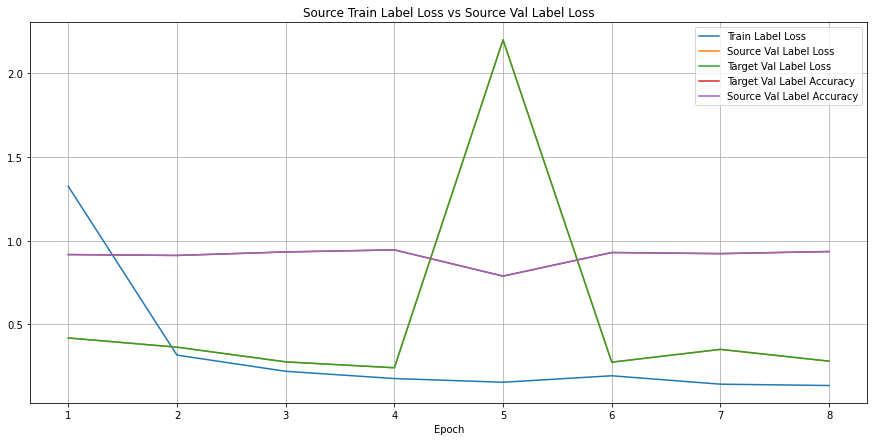

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

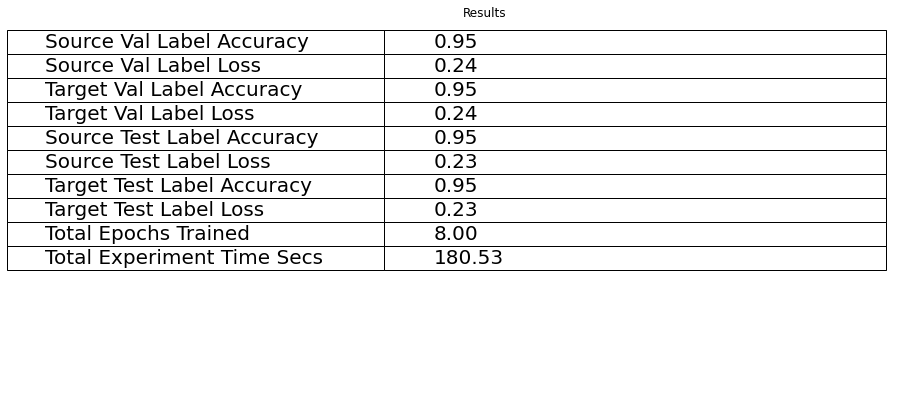

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

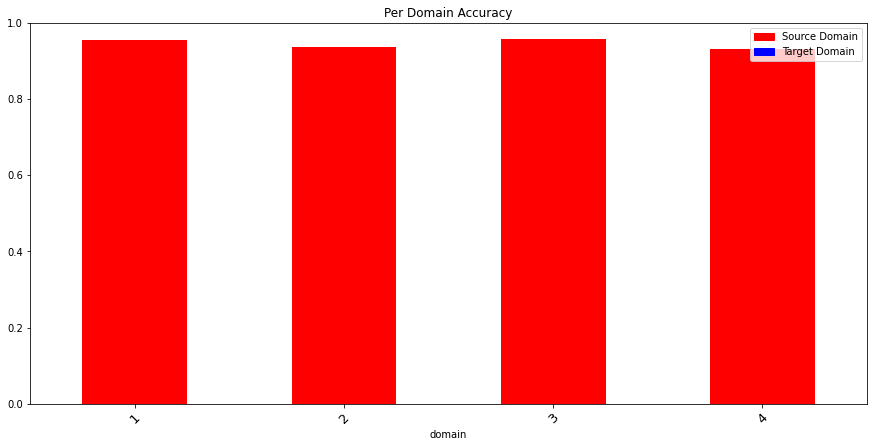

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9489907720776217 Target Test Label Accuracy: 0.9489907720776217
Source Val Label Accuracy: 0.9456586381207256 Target Val Label Accuracy: 0.9456586381207256


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:wisig", "parameters": {"experiment_name": "cnn_2:wisig", "labels": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "3-18", "3-2", "3-8", "4-1", "4-10", "4-11", "5-